# Time Accounting for the DDF Program in 2023A Semester
by Melissa Graham, 2022-07-16, adapted Jan 2023 by Guy Nir, adapted Feb 2024 by Rob Knop

<br>
<br>

## 0. Imports and Definitions

In [17]:
import glob,os,sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import pandas

Define today's date and a line will be drawn on the plots below.

In [18]:
today = '2024-02-20'
today_mjd = Time(today+'T00:00:00.00', format='isot', scale='utc').mjd

Define the number of hours per night.

A semesters are 11.3 hours/night.
B semesters are 8.3 hours/night.

In [19]:
hours_per_night = 11.3

Define the number of nights awarded to the DDF. (Also from Alfredo's email.)

In [20]:
nights_awarded_DDF = 6.5

## 1. Time Used by the DDF in 24A

Get the list of all the qcinv files to date.

In [21]:
qcinv_fnms = glob.glob( '../../2024A/*/*.qcinv')

Generate the list of dates and modified julian dates in the qcinv files.

In [22]:
temp = []
for qfnm in qcinv_fnms:
    t1 = qfnm.split('/')[4]
    t2 = t1.split('.')[0]
    temp.append( t2[0:4]+'-'+t2[4:6]+'-'+t2[6:8] )
    del t1,t2
qcinv_dates = np.sort( np.asarray( temp, dtype='str' ) )
del temp

temp = []
for qdate in qcinv_dates:
    temp.append( Time(qdate+'T00:00:00.00', format='isot', scale='utc').mjd )
qcinv_mjds = np.asarray( temp, dtype='float' )
del temp

for q in range(len(qcinv_dates)):
    print(qcinv_dates[q],qcinv_mjds[q])

2024-02-02 60342.0
2024-02-05 60345.0
2024-02-08 60348.0
2024-02-11 60351.0
2024-02-14 60354.0
2024-02-17 60357.0


Generate arrays of the observations from the qcinv files.

In [23]:
### Set true if you want debugging output
verbose_level_1 = False
verbose_level_2 = False

temp1 = []
temp2 = []
temp3 = []
temp4 = []

for q,qfnm in enumerate(qcinv_fnms):
    f = open(qfnm)
    lines = f.readlines()
    last_target = 'other'
    start_time = '-:-'
    end_time = '-:-'
    for l,line in enumerate(lines):
        if (line[0:1] != '#'):

            ### Check if this line was a DDF observation
            tx_EL = line.find('ELAIS')
            tx_CO = line.find('COSMOS')
            tx_DE = line.find('DECaPS-East')
            tx_DW = line.find('DECaPS-West')
            if verbose_level_2 == True:
                print(last_target, tx_EL, tx_CO, tx_DE, tx_DW, start_time, end_time)

            ### If this line is a change in field, we now know the end time of a sequence
            if (line[0:1] != 'M') & (line[0:1] != 'p'):
                useline = line
            else:
                useline = lines[l-1] # this will only cause the loss of ~1 minute from accounting
            if (last_target == 'ELAIS') & (tx_EL < 0):
                end_time = useline.split()[3]
            if (last_target == 'COSMOS') & (tx_CO < 0):
                end_time = useline.split()[3]
            if (last_target == 'DECaPS-East') & (tx_DE < 0):
                end_time = useline.split()[3]
            if (last_target == 'DECaPS-West') & (tx_DW < 0):
                end_time = useline.split()[3]
            del useline

            ### If a sequence has ended, append it to our list of observations
            if end_time != '-:-':
                temp1.append(qcinv_dates[q])
                temp2.append(qcinv_mjds[q])
                temp3.append(last_target)
                start = float(start_time.split(':')[0]) + float(start_time.split(':')[1])/60.0
                end   = float(end_time.split(':')[0]) + float(end_time.split(':')[1])/60.0
                if start > 20.0:
                    start = start - 24.0
                if end > 20.0:
                    end = end - 24.0
                temp4.append( np.round( end - start, 3) )
                if verbose_level_1 == True:
                    print('seq end: ',qcinv_dates[q],qcinv_mjds[q],last_target,np.round( end - start, 3))
                start_time = '-:-'
                end_time = '-:-'
                del start, end

            ### If this sequence was the first on one of our fields, it's a new start time
            if (tx_EL >= 0) & (last_target != 'ELAIS'):
                start_time = line.split()[3]
            if (tx_CO >= 0) & (last_target != 'COSMOS'):
                start_time = line.split()[3]
            if (tx_DE >= 0) & (last_target != 'DECaPS-East'):
                start_time = line.split()[3]
            if (tx_DW >= 0) & (last_target != 'DECaPS-West'):
                start_time = line.split()[3]

            if tx_EL >= 0:
                last_target = 'ELAIS'
            if tx_CO >= 0:
                last_target = 'COSMOS'
            if tx_DE >= 0:
                last_target = 'DECaPS-East'
            if tx_DW >= 0:
                last_target = 'DECaPS-West'
            if (tx_EL < 0) & (tx_CO < 0) & (tx_DE < 0) & (tx_DW < 0):
                last_target = 'other'

            del tx_EL, tx_CO, tx_DE, tx_DW
    
    f.close()
    del f, lines, last_target, start_time, end_time

obs_date  = np.asarray( temp1, dtype='str' )
obs_mjd   = np.asarray( temp2, dtype='float' )
obs_fname = np.asarray( temp3, dtype='str' )
obs_dtime = np.asarray( temp4, dtype='float' )

del temp1,temp2,temp3,temp4
del verbose_level_1, verbose_level_2

Quick check for how many DDF observations were retrieved.

In [24]:
print(len(obs_date))
print(obs_date)

9
['2024-02-02' '2024-02-02' '2024-02-05' '2024-02-05' '2024-02-08'
 '2024-02-11' '2024-02-14' '2024-02-14' '2024-02-17']


Generate a cumulative time based on the observations listed in the qcinv files.

In [25]:
temp = []
for o,dtime in enumerate(obs_dtime):
    if o == 0:
        temp.append( dtime )
    else:
        temp.append( temp[o-1] + dtime )
obs_ctime = np.asarray( temp, dtype='float' )
del temp

Print all sequences and their cumulative time in hours.

In [26]:
# for o,date in enumerate(obs_date):
#     print('%10s  %7.1f  %11s  %5.2f  %5.2f' % \
#           (obs_date[o], obs_mjd[o], obs_fname[o], obs_dtime[o], obs_ctime[o]) )

Plot the cumulative time used by the DDF as a function of MJD.

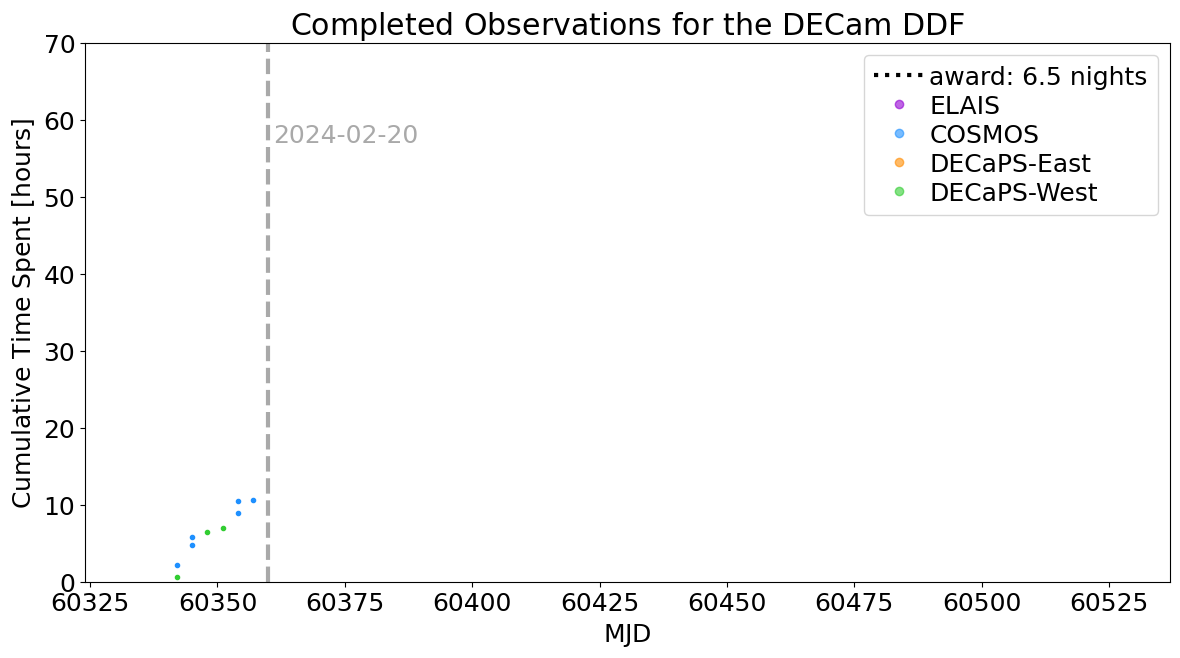

In [27]:
mjd0 = 60324
mjd1 = 60537

fig = plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size':18})

### horizontal dotted line at the DDF time awarded
plt.axhline( nights_awarded_DDF*hours_per_night, ls='dotted', lw=3, alpha=1, color='black', \
            label='award: '+str(np.round(nights_awarded_DDF,1))+' nights' )

### verticle dashed line at "today"
plt.axvline( today_mjd, ls='dashed', lw=3, alpha=1, color='darkgrey')
plt.text( today_mjd+1, 57, today, color='darkgrey')

for o in range(len(obs_mjd)):
    if obs_fname[o] == 'ELAIS':
        point_color = 'darkviolet'
    if obs_fname[o] == 'COSMOS':
        point_color = 'dodgerblue'
    if obs_fname[o] == 'DECaPS-East':
        point_color = 'darkorange'
    if obs_fname[o] == 'DECaPS-West':
        point_color = 'limegreen'
    plt.plot( obs_mjd[o], obs_ctime[o], 'o', ms=3, alpha=1, color=point_color )

plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkviolet', label='ELAIS' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='dodgerblue', label='COSMOS' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkorange', label='DECaPS-East' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='limegreen', label='DECaPS-West' )
    
plt.xlim([mjd0,mjd1])
plt.ylim([0,70])
plt.xlabel(r'${\rm MJD}$',fontsize=18)
plt.ylabel(r'${\rm Cumulative\ Time\ Spent\ [hours]}$',fontsize=18)
plt.title(r'${\rm Completed\ Observations\ for\ the\ DECam\ DDF}$')
plt.legend(loc='best',handletextpad=0.2,labelspacing=0.2,fontsize=18,numpoints=1,ncol=1)
plt.show()

## 2. Projected Time Used by the DDF in 23A.

Based on the fixed scheduler file.

Read in data from DDF_fixed_scheduler_file.txt, convert dates to MJD.

In [28]:
fsf_date  = np.loadtxt( 'DDF_fixed_scheduler_file.txt', dtype='str', usecols={0} )
fsf_seqid = np.loadtxt( 'DDF_fixed_scheduler_file.txt', dtype='str', usecols={1} )
fsf_dtime = np.loadtxt( 'DDF_fixed_scheduler_file.txt', dtype='float', usecols={4} )

Create array that is just the fixed schedule file field names (fsf_fname).

In [29]:
temp = []
for fid in fsf_seqid:
    temp.append( fid.split('-')[0] )
fsf_fname = np.asarray( temp, dtype='str' )
del temp

Convert the calendar dates in the fixed schedule file to modified julian dates (fsf_mjd).

In [30]:
temp = []
for fdate in fsf_date:
    temp.append( Time(fdate+'T00:00:00.00', format='isot', scale='utc').mjd )
fsf_mjd = np.asarray( temp, dtype='float' )
del temp

In [31]:
# Show how much time we're using each night
df = pandas.DataFrame( { 'date': fsf_date, 'name': fsf_fname, 'dtime': fsf_dtime } )
df.groupby( 'date' ).apply( 'sum' )['dtime'] * 60

date
2024-02-02     32.4
2024-02-06     56.4
2024-02-08     88.8
2024-02-11     32.4
2024-02-14     56.4
2024-02-17     88.8
2024-02-20    117.0
2024-02-29    117.0
2024-03-03    120.6
2024-03-06    120.6
2024-03-09     32.4
2024-03-12    120.6
2024-03-15     32.4
2024-04-02    120.6
2024-04-05    120.6
2024-04-08     88.2
2024-04-11    120.6
2024-04-14    120.6
2024-04-17    120.6
2024-04-18     88.2
2024-04-20    120.6
2024-04-23    120.6
2024-04-26    120.6
2024-04-29    120.6
2024-05-02    120.6
2024-05-05    120.6
2024-05-08    120.6
2024-05-11    120.6
2024-05-14    120.6
2024-05-17    120.6
2024-05-18     88.2
2024-05-19    120.6
2024-05-29    120.6
2024-06-01     92.4
2024-06-04     60.0
2024-06-07     92.4
2024-06-10     32.4
2024-06-13     32.4
2024-06-16     92.4
2024-06-25     92.4
2024-06-27     60.0
2024-06-28     92.4
2024-07-01     92.4
2024-07-04     92.4
2024-07-07     60.0
2024-07-10     92.4
2024-07-13     92.4
2024-07-14     60.0
2024-07-15     62.4
2024-07-16     

In [16]:
print( 'Total planned time is %5.2f hours' % np.sum(fsf_dtime) )
print( 'Assuming %3.1f hours a night, that is %4.2f nights.' % \
      (hours_per_night,(np.sum(fsf_dtime)/hours_per_night)) )
print( 'And the DDF was awarded '+str(np.round(nights_awarded_DDF,1))+' nights.')

Total planned time is 79.65 hours
Assuming 11.3 hours a night, that is 7.05 nights.
And the DDF was awarded 6.5 nights.


Generate array of cumulative time spent, if the plan is followed (fsf_dtimeC).

In [48]:
temp = []
for f,fdt in enumerate(fsf_dtime):
    if f == 0:
        temp.append( fsf_dtime[f] )
    else:
        temp.append( temp[f-1]+fsf_dtime[f] )
fsf_dtimeC = np.asarray( temp, dtype='float' )
del temp

Generate array of "IDEAL" cumulative time spent which is the total time divided equally between epochs.

Generate array of unique dates (i.e., epochs).

In [49]:
udates = np.unique( fsf_date )
temp = []
for udate in udates:
    temp.append( Time(udate+'T00:00:00.00', format='isot', scale='utc').mjd )
udates_mjd = np.asarray( temp, dtype='float' )
del temp

Calculate the "IDEAL" number of hours per night, using hours_per_night hours per night and the assigned nights_awarded_DDF nights.

In [50]:
awarded_hours = nights_awarded_DDF * hours_per_night
number_of_epochs = float( len(udates) )
ideal_hours_per_epoch = awarded_hours / number_of_epochs
str_ihpe = str( np.round(ideal_hours_per_epoch,1) )

Generate the array of "IDEAL" cumulative time spent (udates_ideal_ctime).

In [51]:
temp = []
for u,udate in enumerate(udates):
    if u == 0:
        temp.append( ideal_hours_per_epoch )
    else:
        temp.append( temp[u-1] + ideal_hours_per_epoch )
udates_ideal_ctime = np.asarray( temp, dtype='float' )
del temp

print('Number of epochs = ',len(udates))

Number of epochs =  53


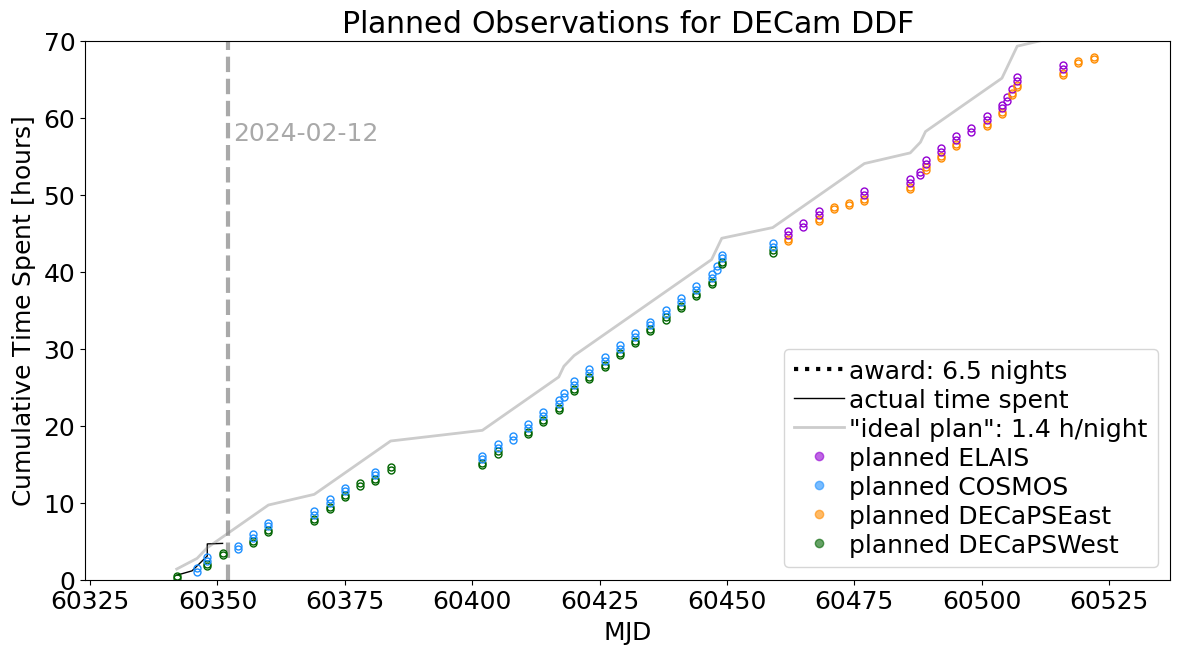

In [52]:
### Plot the cumulative time as a function of MJD

mjd0 = 60324
mjd1 = 60537

fig = plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size':18})

### horizontal dotted line at the DDF time awarded
plt.axhline( nights_awarded_DDF*hours_per_night, ls='dotted', lw=3, alpha=1, color='black', \
            label='award: '+str(np.round(nights_awarded_DDF,1))+' nights' )

### verticle dashed line at "today"
plt.axvline( today_mjd, ls='dashed', lw=3, alpha=1, color='darkgrey')
plt.text( today_mjd+1, 57, today, color='darkgrey')

### plot the actual cumulative time spent so far
plt.plot( obs_mjd, obs_ctime, lw=1, alpha=1, color='black', label='actual time spent')

### plot the cumulative time if we divided the DDF time evenly over all nights
plt.plot( udates_mjd, udates_ideal_ctime, ls='solid', lw=2, alpha=0.4, color='grey', \
         label='"ideal plan": '+str_ihpe+' h/night')

for f in range(len(fsf_mjd)):
    if fsf_fname[f] == 'ELAIS':
        point_color = 'darkviolet'
    if fsf_fname[f] == 'COSMOS':
        point_color = 'dodgerblue'
    if fsf_fname[f] == 'DECaPSEast':
        point_color = 'darkorange'
    if fsf_fname[f] == 'DECaPSWest':
        point_color = 'darkgreen'
    plt.plot( fsf_mjd[f], fsf_dtimeC[f], 'o', ms=5, fillstyle='none', color=point_color )

plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkviolet', label='planned ELAIS' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='dodgerblue', label='planned COSMOS' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkorange', label='planned DECaPSEast' )
plt.plot( -99,-99, 'o', ms=6, alpha=0.6, color='darkgreen', label='planned DECaPSWest' )
    
plt.xlim([mjd0,mjd1])
plt.ylim([0,70])
plt.xlabel(r'${\rm MJD}$',fontsize=18)
plt.ylabel(r'${\rm Cumulative\ Time\ Spent\ [hours]}$',fontsize=18)
plt.title(r'${\rm Planned\ Observations\ for\ DECam\ DDF}$')
plt.legend(loc='best',handletextpad=0.2,labelspacing=0.2,fontsize=18,numpoints=1,ncol=1)
plt.show()

In [ ]:
obs_dtime